Laboratorium miało na celu zapoznanie się z charakterystyką filtrów NOI oraz zaprojektowanie własnych filtrów NOI celem dostrzeżenia różnic, na które wpływ miały poszczególne parametry filtra.

Importy:

In [1]:
from typing import Iterable, Tuple
from scipy.io import wavfile
from scipy.signal import iirfilter, freqs, sosfreqz, sosfiltfilt, firwin
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft
from enum import Enum
import cmath

Enum określający dostępne to użycia rodzaje aproksymacji.

In [2]:
class IirTypeFilter(Enum):
    BUTTERWORTH = 'butter'
    CHEBYSHEV_1 = 'cheby1'
    CHEBYSHEV_2 = 'cheby2'
    ELLIPTIC = 'ellip'
    BESSEL = 'bessel'

Enum określający typ filtra.

In [3]:
class FilterTypeEnum(Enum):
    BANDPASS = 'bandpass'
    LOWPASS = 'lowpass'
    HIGHPASS = 'highpass'
    BANDSTOP = 'bandstop'

Określenie zakresów częstotliwości dolnych oraz górnych poszczególnych oktaw oraz tercji.

In [4]:
octaves = [
    [11.3, 22.6],
    [22.3, 44.5],
    [44.5, 89.1],
    [88.4, 177],
    [177, 354],
    [354, 707],
    [707, 1414],
    [1414, 2828],
    [2828, 5657],
    [5657, 11314],
    [11314, 22627],
]

terces = [
    [11.1, 14.0],
    [14.3, 18.0],
    [17.8, 22.4],
    [22.3, 28.1],
    [28.1, 35.4],
    [35.6, 44.9],
    [44.5, 56.1],
    [56.1, 70.7],
    [71.3, 89.8],
    [89.1, 112.2],
    [111.4, 140.3],
    [142.5, 179.6],
    [178.2, 224.5],
    [222.7, 280.6],
    [280.6, 353.6],
    [356.4, 449.0],
    [445.4, 561.2],
    [561.3, 707.2],
    [712.7, 898.0],
    [890.9, 1122.5],
    [1113.6, 1404.1],
    [1425.4, 1795.9],
    [1781.8, 2244.9],
    [2227.2, 2806.2],
    [2806.3, 3535.8],
    [3563.6, 4489.8],
    [4454.5, 5612.3],
    [5612.7, 7071.5],
    [7127.2, 8979.7],
    [8909.0, 11224.6],
    [11136.2, 14030.8],
    [14254.4, 17959.4],
    [17818.0, 22449.2],
]

Funkcja dokonująca zamiany danych sygnału do skali decybelowej.

In [5]:
def transform_data_to_db_scale(data: np.array) -> np.array:
    data_max = np.max(data)

    return 10 * np.log10(data / data_max)

Klasa reprezentująca filtry SOI z poprzednich zajęć.

In [6]:
class Filter:
    def __init__(self, data: np.array, max_freq: int):
        self.data = data
        self.max_freq = max_freq
        self.fs = max_freq * 2

        self.amplitude_characteristic: np.array = None
        self.amplitude_characteristic_decibel: np.array = None
        self.phase_characteristic: np.array = None

        self.boundary_decibel: int = None
        self.boundary_frequencies: np.array = None
        self.bandwidth: int = None

    def get_amplitude_characteristic(self) -> np.array:
        if self.amplitude_characteristic is None:
            self.calc_freq_characteristic(True)

        return self.amplitude_characteristic

    def get_phase_characteristic(self) -> np.array:
        if self.phase_characteristic is None:
            self.calc_freq_characteristic(True)

        return self.phase_characteristic

    def get_amplitude_characteristic_decibel(self) -> np.array:
        if self.amplitude_characteristic_decibel is None:
            self.calc_freq_characteristic_params(True)

        return self.amplitude_characteristic_decibel

    @property
    def shape(self) -> tuple:
        return self.data.shape

    def calc_freq_characteristic(self, force: bool = False) -> None:
        if force is False and self.amplitude_characteristic is not None and self.phase_characteristic is not None:
            return

        h_vals = []
        angle = []

        for freq in range(self.max_freq):
            omega = 2 * np.pi * freq / self.fs
            h = 0
            # h = np.sum(self.data) * np.exp(-1j * omega * np.arange(self.shape[0]))

            for fir_iter, fir_val in enumerate(self.data):
                h += fir_val * np.exp(-1j * omega * fir_iter)

            h_vals.append(h)
            angle.append(np.degrees(cmath.phase(h)))

        self.amplitude_characteristic = np.abs(h_vals)
        self.phase_characteristic = np.array(angle)

    def calc_freq_characteristic_params(self, force: bool = False) -> None:
        if force is False and self.boundary_frequencies is not None and self.bandwidth is not None:
            return

        if self.amplitude_characteristic is None:
            self.calc_freq_characteristic(True)

        self.amplitude_characteristic_decibel = transform_data_to_db_scale(self.amplitude_characteristic)
        max_decibel = np.max(self.amplitude_characteristic_decibel)

        self.boundary_frequencies = np.ones(2, dtype=int) * -1
        self.boundary_decibel = max_decibel - 3

        for freq, decibel in enumerate(self.amplitude_characteristic_decibel):
            if self.boundary_frequencies[0] == -1 and decibel > self.boundary_decibel:
                self.boundary_frequencies[0] = freq
                continue

            if self.boundary_frequencies[0] != -1 and decibel < self.boundary_decibel:
                self.boundary_frequencies[1] = freq
                break

        self.bandwidth = self.boundary_frequencies[1] - self.boundary_frequencies[0]

    def get_decibels_for_boundary_frequencies(self) -> np.array:
        if self.amplitude_characteristic_decibel is None:
            self.calc_freq_characteristic_params(True)

        return np.array([
            self.amplitude_characteristic_decibel[self.boundary_frequencies[0]],
            self.amplitude_characteristic_decibel[self.boundary_frequencies[1]],
        ])

    def get_params(self) -> dict:
        if self.boundary_frequencies is None or self.bandwidth is None:
            self.calc_freq_characteristic_params(True)

        return {
            'max_freq': self.max_freq,
            'fs': self.fs,
            'boundary_frequencies': self.boundary_frequencies,
            'bandwidth': self.bandwidth,
        }


Klasa wizualizująca filtry SOI z poprzednich zajęć.

In [7]:
class FilterVisualizer:
    @staticmethod
    def visualise_amplitude(fir: Filter, params: dict = {}) -> None:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(np.arange(fir.max_freq), fir.get_amplitude_characteristic())
        ax.set_title('Amplitude characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        if 'text' in params.keys():
            ax.text(-0.15, 0.95, params['text'], transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.5))

        plt.show()
        plt.close(fig)

    @staticmethod
    def visualise_phase(fir: Filter, params: dict = {}) -> None:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(np.arange(fir.max_freq), fir.get_phase_characteristic())
        ax.set_title('Phase characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        if 'text' in params.keys():
            ax.text(-0.15, 0.95, params['text'], transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='green', alpha=0.5))

        plt.show()
        plt.close(fig)

    @staticmethod
    def visualize_amplitude_db(fir: Filter) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(np.full(fir.get_amplitude_characteristic_decibel().shape[0], fir.boundary_decibel))
        plt.plot(np.arange(fir.max_freq), fir.amplitude_characteristic_decibel)
        plt.scatter(fir.boundary_frequencies, fir.get_decibels_for_boundary_frequencies())
        plt.title(f'Amplitude characteristics in dB, bandwidth: {fir.bandwidth}Hz')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Level [dB]')
        plt.show()
        plt.close()


Pomocnicza klasa (jako util) zawierająca metody statyczne. Służy do wizualizacji wykresów pojedyncznych i podwójnych celem ich porównania. Pozwala na wizualizację:
* charakterystyki amplitudowej
* charakterystyki częstotliwościowej
* widma
* spektrogramu
* przebiegu sygnału

In [20]:
class Visualizer:
    @staticmethod
    def visualise_amplitude(data: np.array) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(np.abs(data))
        plt.title('Amplitude characteristics')
        plt.xlabel('Hz')
        plt.ylabel('H(jΩ)')
        plt.show()
        plt.close()

    @staticmethod
    def visualise_phase(data: np.array) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(np.unwrap(np.angle(data)))
        plt.title('Phase characteristics')
        plt.xlabel('Hz')
        plt.ylabel('H(jΩ)')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_spectrum(data: np.array) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(np.abs(fft(data)))
        plt.title('Spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_spectrogram(data: np.array, fs: int = 2) -> None:
        plt.figure(figsize=(20, 10))
        plt.specgram(data, Fs=fs, NFFT=4096)
        plt.title('Spectrogram')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_signal(data: np.array) -> None:
        plt.figure(figsize=(20, 10))
        plt.plot(data)
        plt.title('Signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_octaves(data: np.array) -> None:
        spectrum = np.abs(fft(data))
        octaves_bands = np.empty(len(octaves))
        x = np.arange(1, len(octaves_bands) + 1)

        for octave_iter, octave in enumerate(octaves):
            octaves_bands[octave_iter] = np.mean(spectrum[int(octave[0]):int(octave[1])])

        plt.figure(figsize=(20, 10))
        plt.bar(x, octaves_bands, width=0.3)
        plt.title('Octave bands')
        plt.xticks(x)
        plt.xlabel('Octave number')
        plt.ylabel('Amplitude')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_terces(data: np.array) -> None:
        spectrum = np.abs(fft(data))
        terces_bands = np.empty(len(terces))
        x = np.arange(1, len(terces_bands) + 1)

        for terce_iter, terce in enumerate(terces):
            terces_bands[terce_iter] = np.mean(spectrum[int(terce[0]):int(terce[1])])

        plt.figure(figsize=(20, 10))
        plt.bar(x, terces_bands, width=0.3)
        plt.title('Terce bands')
        plt.xticks(x)
        plt.xlabel('Terce number')
        plt.ylabel('Amplitude')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_comparison_amplitude(data1: np.array, data2: np.array):
        plt.figure(figsize=(20, 10))

        ax = plt.subplot(2, 1, 1)
        ax.plot(np.abs(data1))
        ax.set_title('Amplitude characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        ax = plt.subplot(2, 1, 2)
        ax.plot(np.abs(data2))
        ax.set_title('Amplitude characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        plt.show()
        plt.close()

    @staticmethod
    def visualize_comparison_phase(data1: np.array, data2: np.array) -> None:
        plt.figure(figsize=(20, 10))

        ax = plt.subplot(2, 1, 1)
        ax.plot(np.unwrap(np.angle(data1)))
        ax.set_title('Phase characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        ax = plt.subplot(2, 1, 2)
        ax.plot(np.unwrap(np.angle(data2)))
        ax.set_title('Phase characteristics')
        ax.set_xlabel('Hz')
        ax.set_ylabel('H(jΩ)')

        plt.show()
        plt.close()

    @staticmethod
    def visualize_comparison_spectrum(data1: np.array, data2_filtered: np.array, log_scale: bool = False) -> None:
        plt.figure(figsize=(20, 10))

        ax = plt.subplot(2, 1, 1)
        ax.plot(np.abs(fft(data1)))
        ax.set_title(f'Signal spectrum before apply filter {"in log scale" if log_scale else ""}')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        if log_scale:
            ax.set_yscale('log')

        ax = plt.subplot(2, 1, 2)
        ax.plot(np.abs(fft(data2_filtered)))
        ax.set_title(f'Signal spectrum after apply filter {"in log scale" if log_scale else ""}')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        if log_scale:
            ax.set_yscale('log')

        plt.show()
        plt.close()

    @staticmethod
    def visualize_comparison_spectrogram(data1: np.array, data2: np.array, fs: int) -> None:
        plt.figure(figsize=(20, 10))

        ax = plt.subplot(2, 1, 1)
        ax.specgram(data1, Fs=fs, NFFT=4096)
        ax.set_title('Spectrogram for signal before apply filter')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [Hz]')

        ax = plt.subplot(2, 1, 2)
        ax.specgram(data2.data, Fs=fs, NFFT=4096)
        ax.set_title('Spectrogram for signal after apply filter')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [Hz]')

        plt.show()
        plt.close()

    @staticmethod
    def visualize_comparison_signals(data1: np.array, data2: np.array) -> None:
        plt.figure(figsize=(20, 10))

        ax = plt.subplot(2, 1, 1)
        ax.plot(data1)
        ax.set_title('Signal before filtration')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')

        ax = plt.subplot(2, 1, 2)
        ax.plot(data2.data)
        ax.set_title('Signal after filtration')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')

        plt.show()
        plt.close()


Pomocnicza funkcja służąca do monofonizacji sygnału.

In [9]:
def monophonize(data: np.array) -> np.array:
    return data.sum(axis=1) / 2

Funkcja generująca filtr IIR na podstawie określonych parametrów. 

In [10]:
def generate_filter(fs: int = 48000, fc: Iterable = [50, 200], order: int = 17,
                    btype: FilterTypeEnum = FilterTypeEnum.BANDPASS, ftype: IirTypeFilter = IirTypeFilter.BUTTERWORTH) -> Tuple:
    sos = iirfilter(order, fc, rs=60, analog=False,
                    btype=btype.value, ftype=ftype.value, fs=fs, output='sos')
    w, h = sosfreqz(sos, fs, fs=fs)

    return h, sos

Funkcja z poprzednich zajęć generująca współczynniki dolnoprzepustowego filtru SOI dla zadanych parametrów.

In [11]:
def generate_filter_coefficients(coefficient_number: int, fs: int, fc: int, window: str = 'hamming') -> np.array:
    """
    :param window:
    :param coefficient_number:
    :param fs: sampling frequency
    :param fc: boundary frequency
    :return:
    """
    nyquist_rate = fs / 2
    cutoff_frequency = fc / nyquist_rate

    return firwin(coefficient_number, cutoff_frequency, window=window, pass_zero='lowpass')

Funkcja wizualizująca porównanie sygnału przed filtracją oraz sygnału po filtracji.

In [12]:
def compare_signal_with_filtered(signal_original: np.array, signal_filtered: np.array, fs: int) -> None:
    Visualizer.visualize_comparison_signals(signal_original, signal_filtered)
    Visualizer.visualize_comparison_spectrum(signal_original, signal_filtered)
    Visualizer.visualize_comparison_spectrum(signal_original, signal_filtered, log_scale=True)
    Visualizer.visualize_comparison_spectrogram(signal_original, signal_filtered, fs)

Wygenerowanie pasmowoprzepustowego filtru IIR z rodzajem aproksymacji Czybyszewa stopnia II oraz wizualizacja charakterystyki amplitudowej oraz fazowej.

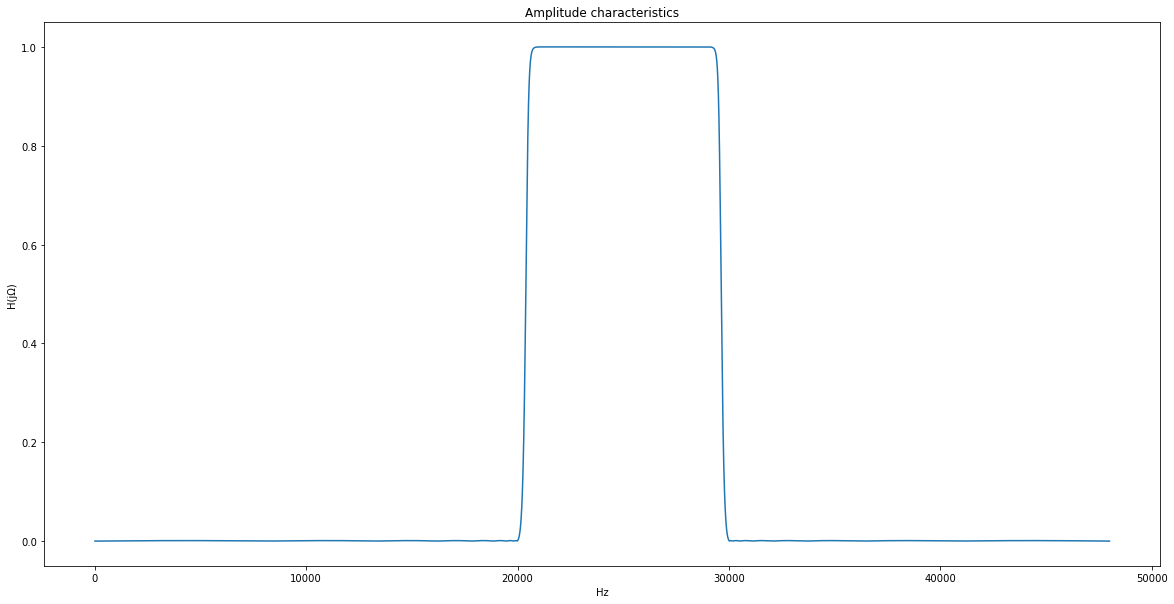

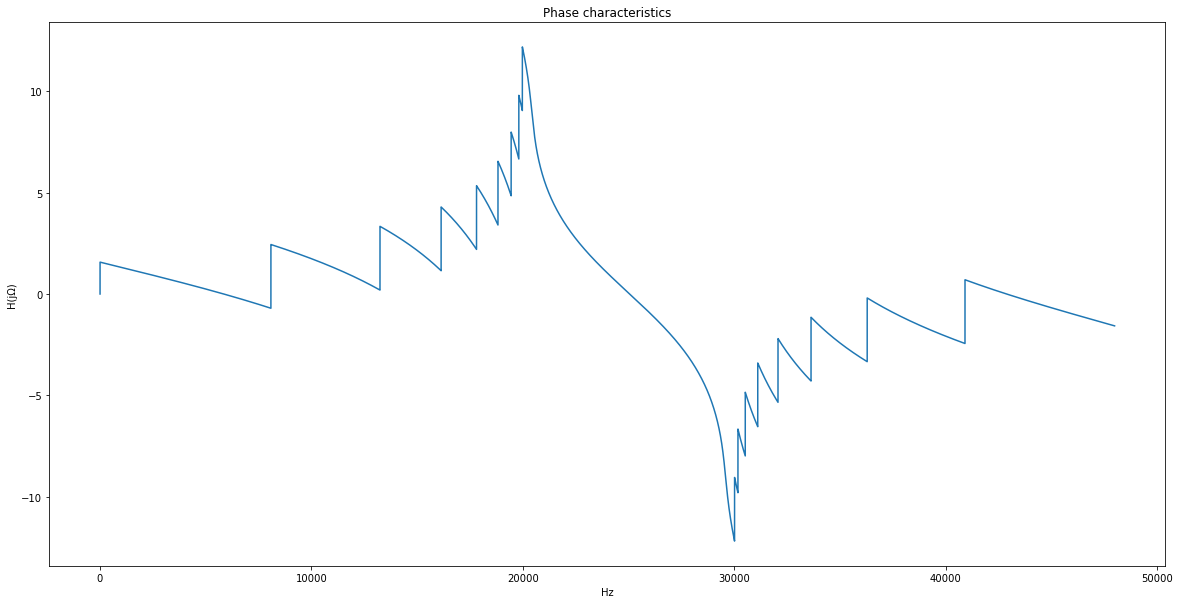

In [13]:
filter_data1, sos_filter1 = generate_filter(48000, [10000, 15000], 17, btype=FilterTypeEnum.BANDPASS, ftype=IirTypeFilter.CHEBYSHEV_2)
Visualizer.visualise_amplitude(filter_data1)
Visualizer.visualise_phase(filter_data1)

Wygenerowanie dolnoprzepustowego filtru IIR z rodzajem aproksymacji Czybyszewa stopnia II podobnego do filtru SOI z poprzednich zajęć oraz wizualizacja charakterystyki amplitudowej oraz fazowej.

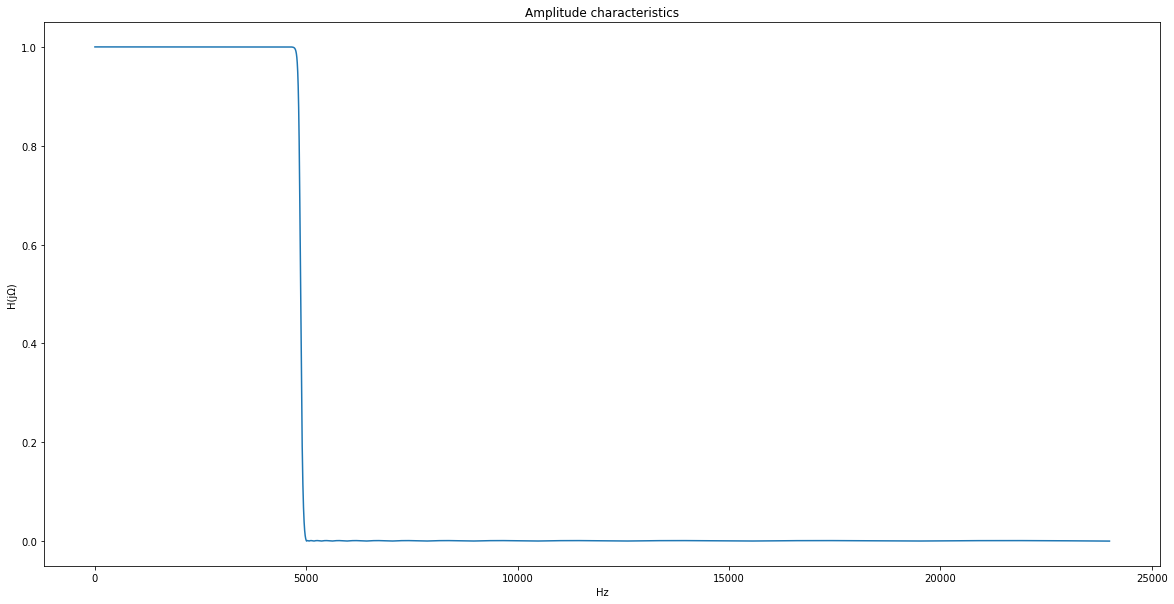

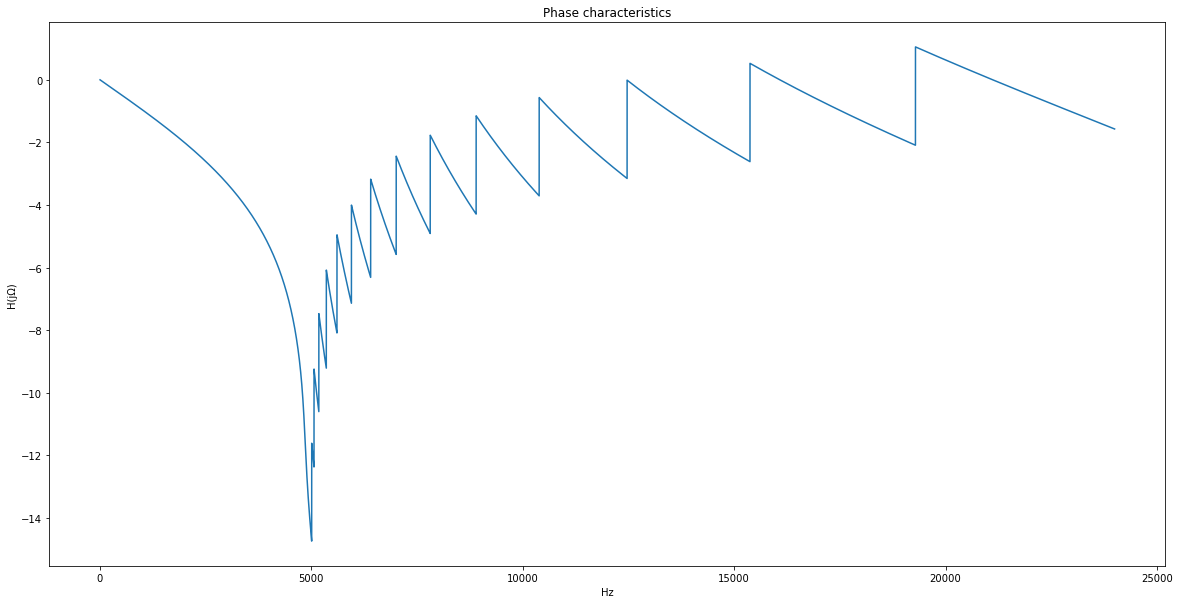

In [14]:
filter_data2, sos_filter2 = generate_filter(24000, [2500], 29, btype=FilterTypeEnum.LOWPASS, ftype=IirTypeFilter.CHEBYSHEV_2)
Visualizer.visualise_amplitude(filter_data2)
Visualizer.visualise_phase(filter_data2)

Wygenerowanie filtru SOI z poprzednich zajęć z użyciem okna Blackmana oraz wizualizacja jego charakterystyk.

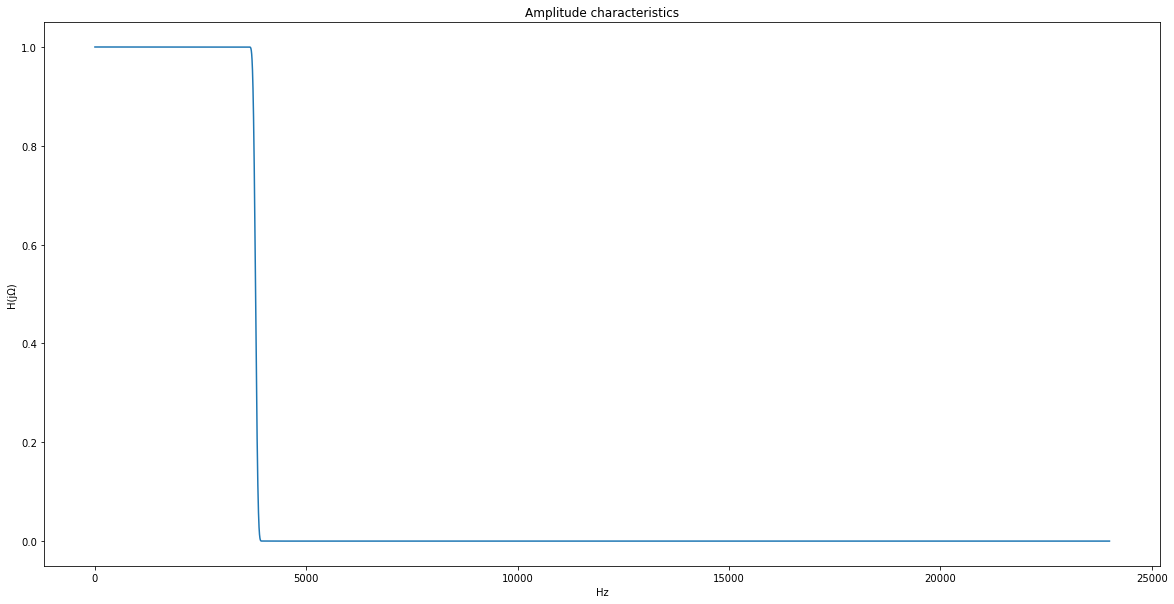

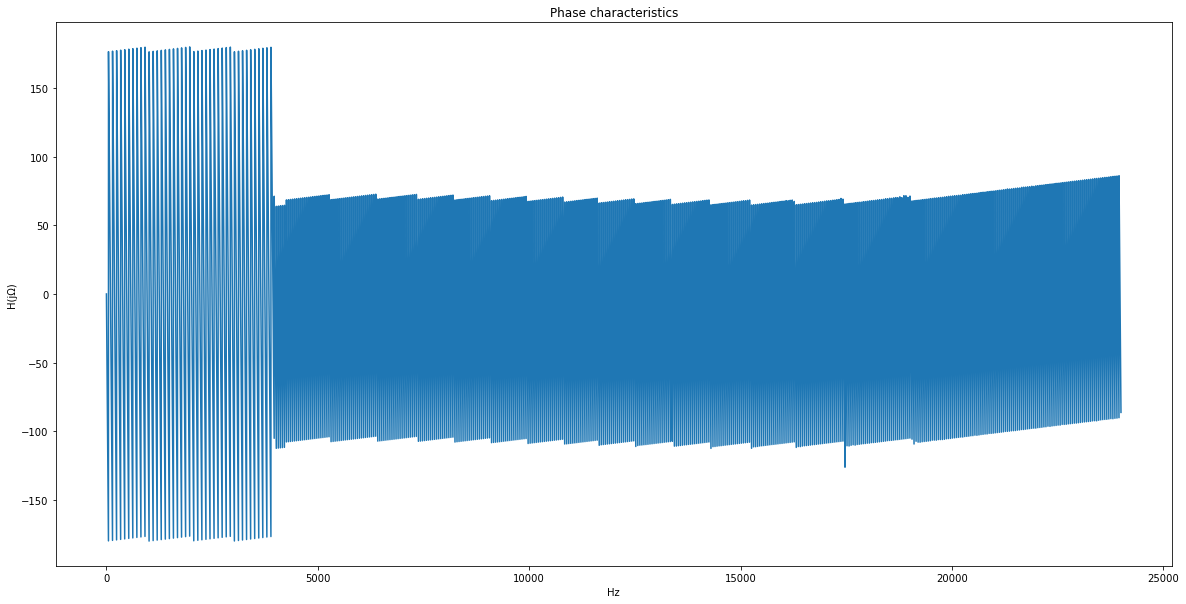

In [15]:
fir_fs = 48000
fir_coefficients = generate_filter_coefficients(1000, fir_fs, 3800, window='blackman')
fir = Filter(fir_coefficients, int(fir_fs / 2))
FilterVisualizer.visualise_amplitude(fir)
FilterVisualizer.visualise_phase(fir)

Wczytanie dowolnego sygnału dźwiękowego, uśrednienie go, a następnie zastosowanie filtra pasmowoprzepustowego NOI.

In [16]:
fs, signal_data = wavfile.read('./signal.wav')
signal_data_monophonized = monophonize(signal_data)
signal_filtered = sosfiltfilt(sos_filter1, signal_data_monophonized)

Porównianie sygnałów przed filtracją oraz po filtracji.

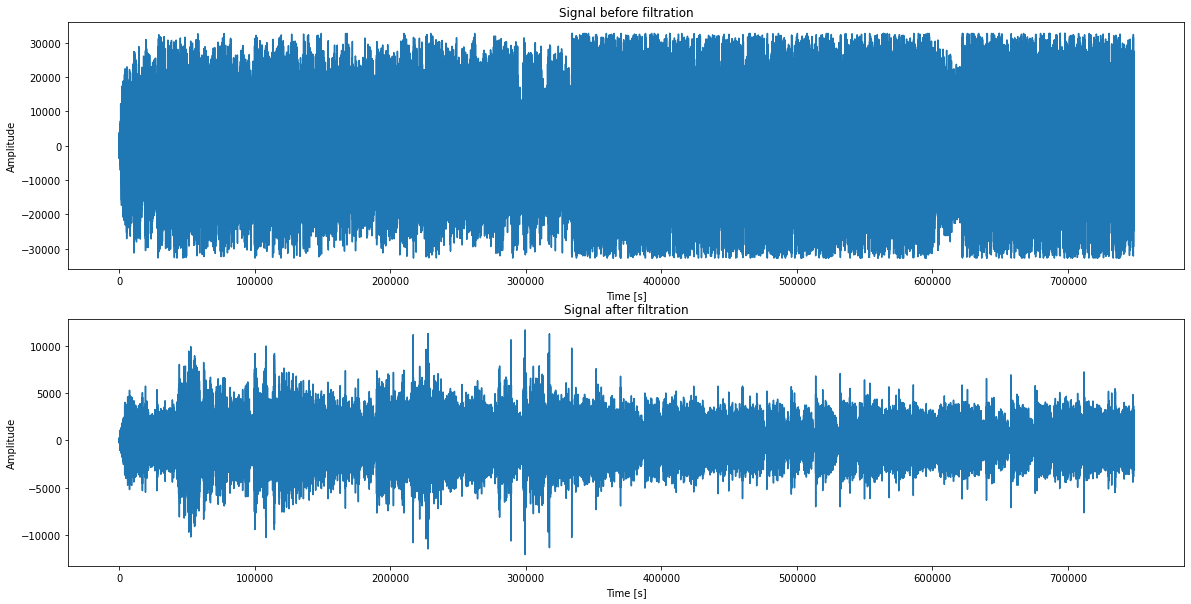

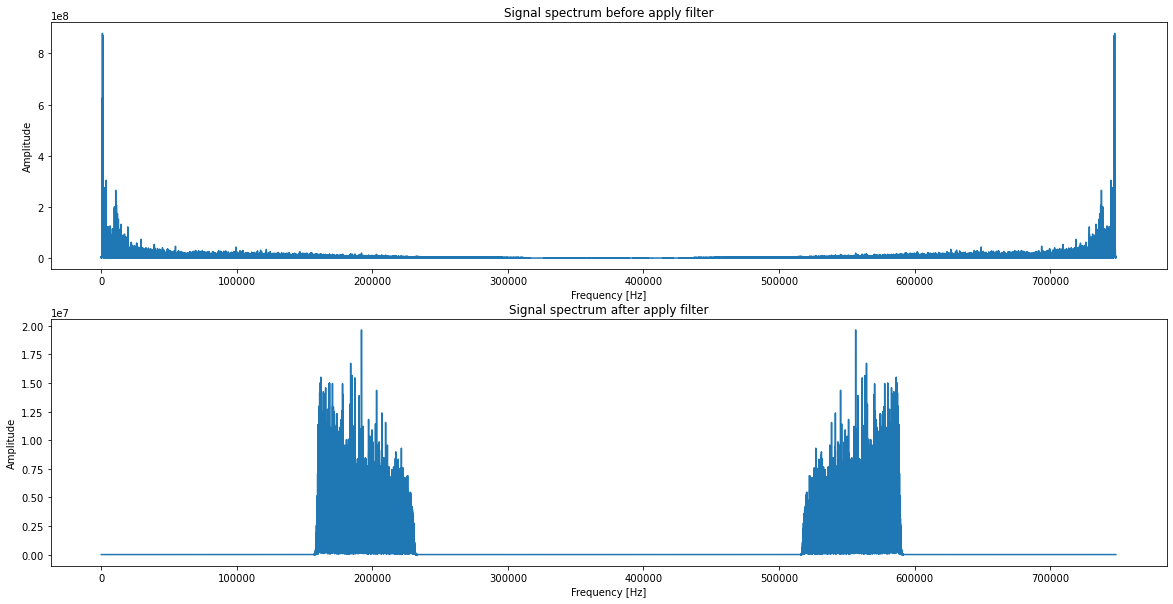

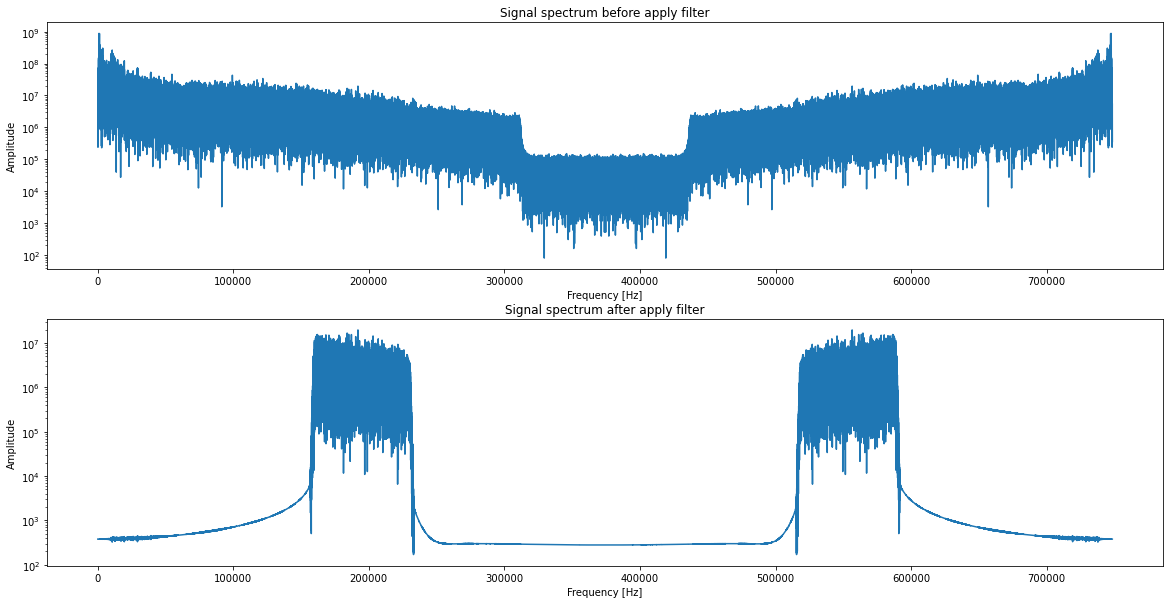

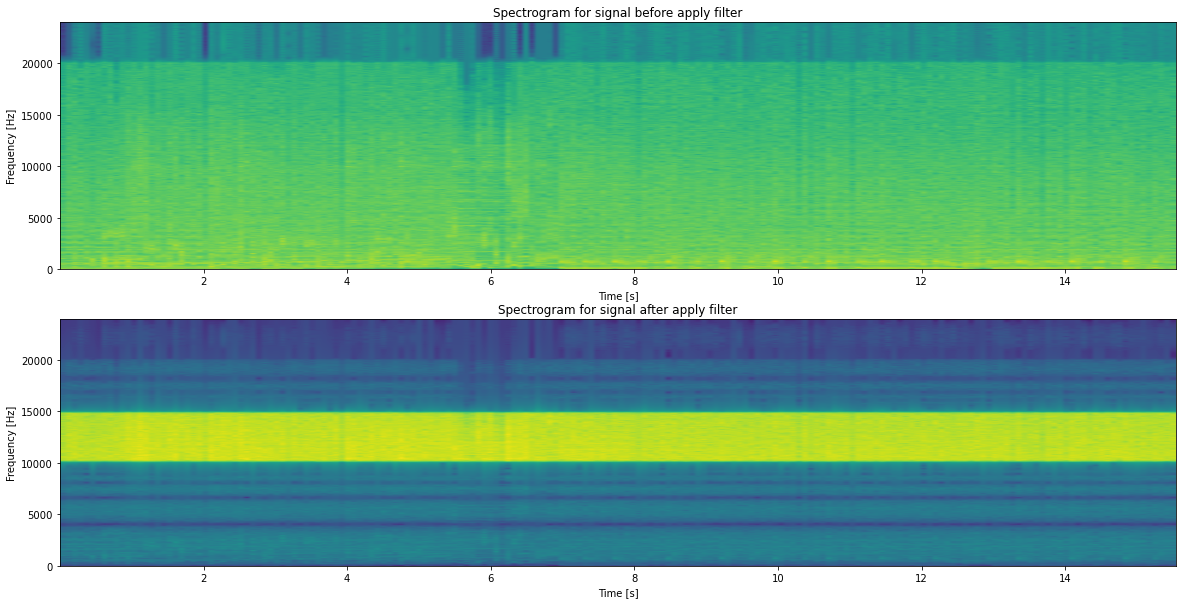

In [17]:
compare_signal_with_filtered(signal_data_monophonized, signal_filtered, fs=fs)

Przedstawienie pasm oktawowych oraz tercjowych dla przefiltrowanego sygnału. Pasma te są wyznaczane na podstawie widma sygnału jako średnia wartość pomiędzy danymi częstotliwościami.

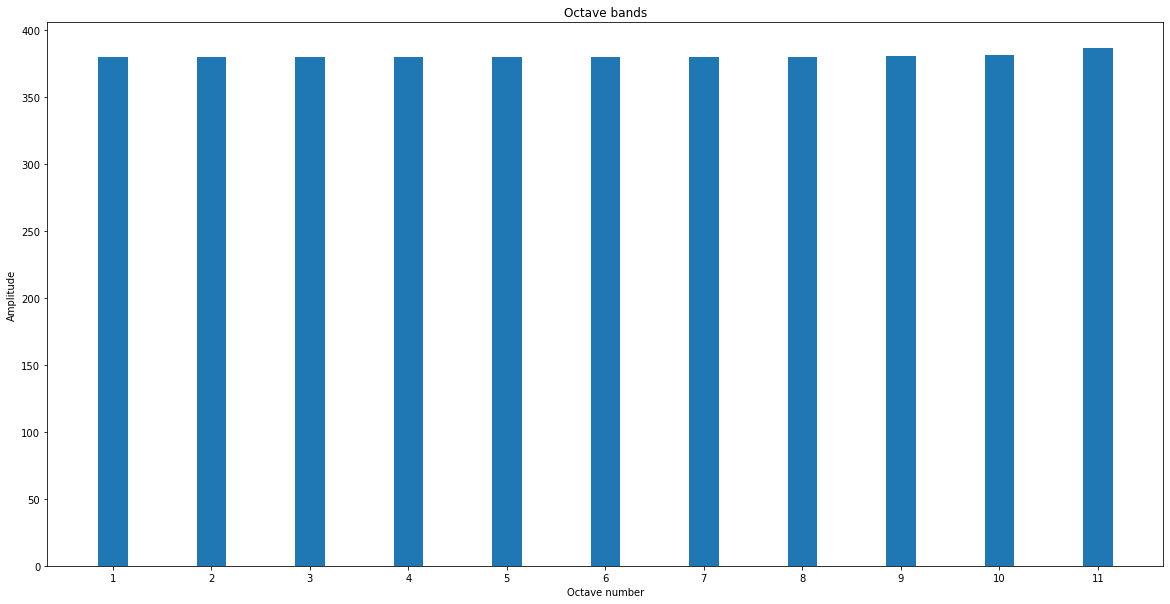

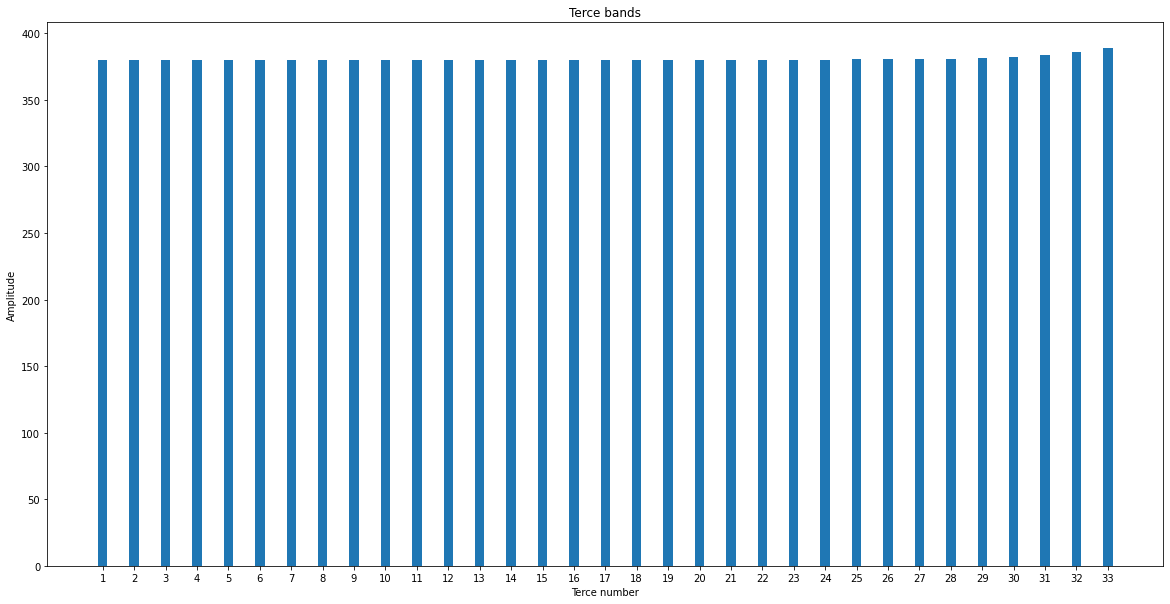

In [21]:
Visualizer.visualize_octaves(signal_filtered)
Visualizer.visualize_terces(signal_filtered)

**UWAGA!** Proszę spojrzeć na wykresy załączone z resztą plików. Te wykresy się źle generują w JupyterLab, nie wiem dlaczego.

Wnioski:
* Zaprojektowany filter, który miał być podobny do poprzedniego na wykresie charakterystyki amplitudowej wygląda identycznie, natomiast ich różnice są widoczne na wykresie obrazującym charakterystykę fazową.
* Pomimo, że przedstawione wykresy nie obrazują różnic pomiędzy poszczególnymi rodzajami aproksymacji, to faktycznie wybór rodzaju apkroksymacji ma wpływ na wygenerowany filtr. Zmiany są widoczne na wykresach charakterystyk amplidutowych oraz częstotliwościowych.
* Rodzaje filtra również mają wpływ na jego wykresy charakterystyk, ale to oczywiste.
* Im większy rząd filtra tym bardziej dokładnie poszczególne wartości w wyznaczonych pasmach częstotliwości są wycinane/przepuszczane.
* Spoglądając na wykresy prążków oktawowych oraz tercjowych **dołączonych wraz z pozostałymi plikami** największe wartości amplitudowe znajdują się po przekroczeniu środka, a następnie maleją.